In [1]:
import os
import re
from dotenv import load_dotenv
from gliner import GLiNER
from unstructured.partition.pdf import partition_pdf
from unstructured.cleaners.core import (clean, 
                                        group_broken_paragraphs, 
                                        clean_extra_whitespace)

from ollama import chat
from pydantic import BaseModel

from langchain.chains import RetrievalQA
from langchain_ollama.llms import OllamaLLM
from langchain_ollama import OllamaEmbeddings
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.vectorstores import InMemoryVectorStore
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter

import networkx as nx
import matplotlib.pyplot as plt



In [2]:
class EdgeList():
    """
    Workflow for generating an edge list from a PDF file.
    file = "TrumpEpstein/PDF/Former Models for Donald Trump’s Agency Say They Violated Immigration Rules and Worked Illegally.pdf"
    file_name = "TrumpEpstein/edge_lists/" + file.split("/")[-1]
    elements = partition_pdf(file)
    sentences = extract_sentences(elements)
    connections = get_connections(sentences, model, labels)
    ### edge_list = create_edge_list(connections, file_name=f"{file_name}.csv")
    ### text = " ".join([s for s in sentences])
    """

    def __init__(self, file: str, ner_threshold: float = 0.55, k: int = 10):
        self.file = file
        self.file_name = None
        self.k = k
        self.ner_threshold = ner_threshold

        # Initialize the GLiNER NER model
        self.model = GLiNER.from_pretrained("numind/NuNER_Zero-span")
        self.labels = ["Person", "Company", "Organization"]

        # Partition the PDF file into elements, extracting sentences and connections
        self.elements = None
        self.sentences = None
        self.connections = None
        self.edge_list = []

        # Initialize the LLM, embeddings, vectorstore
        self.llm = OllamaLLM(model="mistral", temperature=0)
        self.retriever = None
        self.rag_chain = None

    def fit(self):
        # Partition the PDF file into elements, extracting sentences and connections
        self.elements = partition_pdf(self.file)
        self.sentences = self.extract_sentences()

    def transform(self):
        self.connections = self.get_connections()
        self.retriever = self.create_retriever()
        self.rag_chain = self.create_rag_chain()
        self.edge_list = self.create_edge_list()
    
    def fit_transform(self):
        """
        Fit and transform the edge list.
        """
        self.fit()
        self.transform()
        return self.edge_list
    
    def save_edge_list(self, file_name: str):
        """
        Save the edge list to a CSV file.
        """
        with open(file_name, "w") as f:
            for source, target in self.edge_list:
                f.write(f"{source}\t{target}\n")
        print(f"Edge list saved to {file_name}")

    def create_retriever(self):
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=100,chunk_overlap=55) # separators=["\n\n", "\n", ". ", " "]
        embeddings = OllamaEmbeddings(model="mxbai-embed-large")
        vectorstore = InMemoryVectorStore(embeddings)
        docs = []
        for i, s in enumerate(self.sentences):
            docs.append(Document(id=str(i), page_content=s, metadata={"source": self.file_name}))
        all_texts = text_splitter.split_documents(docs)
        vs = vectorstore.from_documents(documents=all_texts, embedding=embeddings)
        retriever = vs.as_retriever(search_kwargs={"k": self.k, "score_threshold": 0.95}) # 0.3
        return retriever
    
    def create_rag_chain(self):
        system_prompt = (
            "You are a precise name identification assistant. Your task is to identify the full name of a person from the given context.\n"
            "The entity type hint is: {entity_type}\n"
            "Rules:\n"
            "1. If the entity type is 'Person' and you find the person's full name (first + last), return it exactly as written\n"
            "2. If the entity type is 'Person' and the name is explicitly mentioned as a pseudonym, fake name, or alias, return 'Name (pseudonym)'\n"
            "3. If the entity type is 'Person' and you cannot find the full name, return 'Name (unknown)'\n"
            "4. If the entity type is 'Organization' or 'Company', return the name as-is without any additional labels\n"
            "5. If the name is mentioned but unclear, or if there are multiple possibilities, return 'Name (unclear)'\n"
            "6. Only use information explicitly stated in the context\n"
            "7. Be factual. Do not invent new names. If you don't know the answer, respond with 'Name (unknown)'\n"
            "8. Be concise - provide only the name and status. Do not include any additional commentary, explanations or formatting.\n\n"
            "Examples:\n"
            "- Input: 'Rachel' (Person) → Output: 'Rachel Blais' (if full name found)\n"
            "- Input: 'Kate' (Person) → Output: 'Kate (pseudonym)' (if mentioned as fake name)\n"
            "- Input: 'Vogue' (Organization) → Output: 'Vogue' (return as-is)\n\n"
            "Context: {context}"
        )
        prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system_prompt),
                ("human", "Name: {input}\nEntity Type: {entity_type}"),
            ]
        )
        qa_chain = create_stuff_documents_chain(self.llm, prompt)
        rag_chain = create_retrieval_chain(self.retriever, qa_chain)
        return rag_chain

    def clean_text(self, text) -> str:
        """
        Cleans the text by applying various cleaning functions.
        """
        text = clean(text)
        text = group_broken_paragraphs(text)
        text = clean_extra_whitespace(text)
        return text

    def extract_sentences(self) -> list:
        self.sentences = []
        for e in self.elements:
            if e.text:
                # Clean the text
                text = self.clean_text(e.text)
                self.sentences.append(text)
        return self.sentences
    
    def get_connections(self):
        self.connections = []
        for sent in self.sentences:
            c = []
            entities = self.model.predict_entities(sent, self.labels, threshold=self.ner_threshold)
            for entity in entities:
                c.append((entity["text"], entity["label"]))
            c = list(set(c))  # Remove duplicates
            if len(c) > 1:
                self.connections.append(c)
        return self.connections
    
    def _identify_person(self, name: str, entity_type: str) -> str:
        """
        Identify a person's full name using the RAG pipeline with structured output.
        """
        # Pass both name and entity_type as separate inputs
        query = {
            "input":  name, # "input": f"Please identify the full name of {name} if it is a person.",
            "entity_type": entity_type
        }
        response = self.rag_chain.invoke(query)
        answer = response['answer'].strip()
        # Post-process the answer for consistency
        return self._format_name_response(name, entity_type, answer)
    
    def _format_name_response(self, input_name: str, entity_type: str, response: str) -> str:
        """
        Format the response to ensure consistent output format.
        """
        response_lower = response.lower()
        # Check for explicit indicators
        if any(indicator in response_lower for indicator in ['pseudonym', 'fake name', 'alias', 'not real']):
            # Extract the name part before adding (pseudonym)
            clean_name = response.split('(')[0].strip() if '(' in response else input_name
            return [clean_name, "(pseudonym)"]
        
        elif any(indicator in response_lower for indicator in ["unclear"]):
            return [input_name, "(unclear)"]

        elif any(indicator in response_lower for indicator in ["don't know", "unknown", "not found"]):
            return [input_name, "(unknown)"]

        elif len(response.split()) >= 2 and not any(word in response_lower for word in ['unknown', 'pseudonym']) or any(word in response_lower for word in ['real', 'real name']):
            # Looks like a full name
            pattern = r'\s*\(real(?:\s+name)?\)'
            cleaned = re.sub(pattern, '', response.strip())
            cleaned = cleaned.strip("'\"")  # Remove any leading/trailing quotes
            # return cleaned
            return [cleaned, "(real name)"]

        else:
            return [input_name, f"({entity_type})"]
        
    def _check_name(self, name, entity_type):
        """ 
        Check if a name is a person using the RAG pipeline. 
        """
        # Define a Pydantic model for structured output
        class Person(BaseModel):
            name: str

        # Retrieve context for the name
        context = " ".join([r.page_content.strip(".").strip() for r in self.retriever.batch([name])[0]])

        # Query the LLM for the person's full name
        response = chat(
        messages=[
            {
            'role': 'user',
            'content': f"""Please identify the full name of {name} if it is a person.
                           This {name} is of type {entity_type}. 
                           Here is some context: {context}. 
                           Provide the full name if available. 
                           If the name is not a person, return the name as is.
                           If the name is not a person (e.g., a company or organization), return the name as is without any additional labels.
                           Return the name without any additional formatting or quotes.""",
            }
        ],
        model='phi3.5', format=Person.model_json_schema(),
        )

        person = Person.model_validate_json(response.message.content)
        return person
    
    def create_edge_list(self):
        """
        Create an edge list from the connections.
        """
        edge_list = []
        for conn in self.connections:
            for i, c in enumerate(conn):
                if i == 0:
                    source, _ = self._final_name_check((c[0], c[1]))
                    continue
                target, _ = self._final_name_check((c[0], c[1]))
                if source == target:
                    continue
                edge_list.append((source, target))
        return list(set(edge_list))

    def _final_name_check(self, entity):
        """
        Given an entity tuple (name, entity_type), returns the best full name match.
        Uses both el._identify_person and el._check_name for comparison.
        
        Args:
            entity: tuple of (name, entity_type) e.g., ('Kate', 'Person')
        
        Returns:
            tuple: (best_name, entity_type)
        
        Examples:
            ('Gehi', 'Person') -> ('Naresh Gehi', 'Person')
            ('Palmer', 'Person') -> ('Alexia Palmer', 'Person') 
            ('Anna', 'Person') -> ('Anna', 'Person') # if no full name found
            ('Vogue', 'Organization') -> ('Vogue', 'Organization')
        """
        name, entity_type = entity
        
        # For non-Person entities, return as-is
        if entity_type in ['Organization', 'Company']:
            return (name, entity_type)
        
        # For Person entities, try to get full names from both methods
        try:
            res1 = el._identify_person(name, entity_type)
            # Handle case where res1 might be a list or string
            if isinstance(res1, list) and len(res1) > 0:
                name1 = res1[0]
            else:
                name1 = str(res1) if res1 else name
        except Exception as e:
            print(f"Error in _identify_person: {e}")
            name1 = name
        
        try:
            res2 = el._check_name(name, entity_type)
            name2 = res2.name if hasattr(res2, 'name') else str(res2)
        except Exception as e:
            print(f"Error in _check_name: {e}")
            name2 = name
        
        # Helper functions
        def is_full_name(candidate_name):
            """Check if a string appears to be a full name (at least 2 words, no status indicators)"""
            if not isinstance(candidate_name, str):
                return False
            
            # Remove common status indicators
            clean_name = candidate_name.lower()
            status_indicators = ['(unknown)', '(pseudonym)', '(unclear)', '(person)', '(real name)']
            
            for indicator in status_indicators:
                if indicator in clean_name:
                    return False
            
            # Check if it has at least 2 words
            words = candidate_name.strip().split()
            return len(words) >= 2
        
        def clean_name(candidate_name):
            """Remove quotes and extra whitespace"""
            if not isinstance(candidate_name, str):
                return str(candidate_name)
            candidate_name = candidate_name.strip("'\"").strip()
            candidate_name = candidate_name.split('(')[0].strip()
            return candidate_name
        
        # Clean the names
        name1_clean = clean_name(name1)
        name2_clean = clean_name(name2)
        
        # Decision logic
        name1_is_full = is_full_name(name1_clean)
        name2_is_full = is_full_name(name2_clean)
        
        # If both results are the same, return that
        if name1_clean.lower() == name2_clean.lower():
            return (name1_clean, entity_type)
        
        # If both are full names, prefer the longer one (more specific)
        if name1_is_full and name2_is_full:
            if len(name1_clean.split()) >= len(name2_clean.split()):
                return (name1_clean, entity_type)
            else:
                return (name2_clean, entity_type)
        
        # If only one result is a full name, prefer it
        if name1_is_full and not name2_is_full:
            return (name1_clean, entity_type)
        elif name2_is_full and not name1_is_full:
            return (name2_clean, entity_type)
        
        # If neither is a full name, return the original name
        # (this handles cases like pseudonyms or when no full name is found)
        return (name, entity_type)


In [3]:
file = "TrumpEpstein/PDF/Former Models for Donald Trump’s Agency Say They Violated Immigration Rules and Worked Illegally.pdf"
el = EdgeList(file=file, k=10, ner_threshold=0.60)
# el.fit()
# el.transform()
edge_list = el.fit_transform()
el.save_edge_list(f"edge_list.tsv")


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

/home/john/nas/deeplearning/Corruption/.venv/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Edge list saved to edge_list.tsv


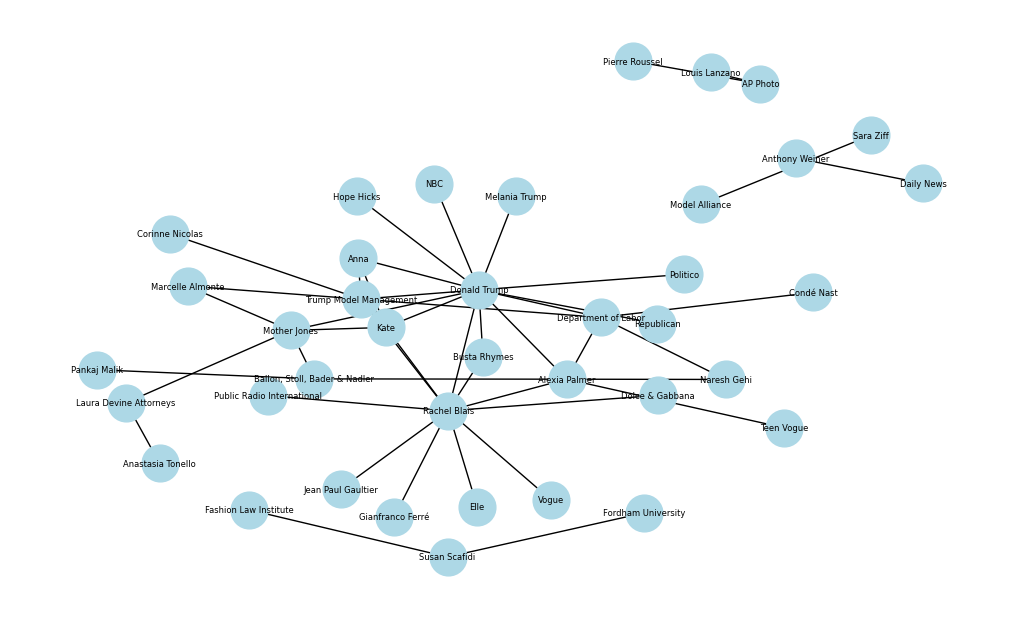

In [4]:
# Read the edge list from the TSV file and create a graph
# G = nx.read_edgelist("edge_list.tsv", delimiter="\t", create_using=nx.DiGraph())
G = nx.read_edgelist("edge_list.tsv", delimiter="\t")

# Draw the graph
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, k=0.5, iterations=50, seed=101)# Fixed layout for consistency
nx.draw(G, pos=pos, with_labels=True, node_size=700, node_color='lightblue', font_size=6, arrows=True)
plt.show()


In [ ]:
for doc in el.retriever.batch(["Melania"])[0]:
    print(doc.page_content)


In [ ]:
for conn in el.connections:
    for i, c in enumerate(conn):
        if i == 0:
            source = c[0]
            continue
        target = c[0]
        if source == target:
            continue
        e = f"{source} -> {target}"
        if "Melania" in e:
            print(e)


In [ ]:
melania_sentences = []
for sent in el.sentences:
    if "Melania" in sent:
        melania_sentences.append(sent)

melania_sentences


In [ ]:
# entities = self.model.predict_entities(sent, self.labels, threshold=0.65)
el.model.predict_entities(melania_sentences[1], el.labels, threshold=0.55)


In [ ]:
# # Example usage:
# entity1 = ('Gehi', 'Person')
# result1 = el._final_name_check(entity1)
# print(result1)  # Expected: ('Naresh Gehi', 'Person')

# entity2 = ('Palmer', 'Person') 
# result2 = el._final_name_check(entity2)
# print(result2)  # Expected: ('Alexia Palmer', 'Person')

# entity3 = ('Anna', 'Person')
# result3 = el._final_name_check(entity3)
# print(result3)  # Expected: ('Anna', 'Person') if no full name found

# entity4 = ('Vogue', 'Organization')
# result4 = el._final_name_check(entity4)
# print(result4)  # Expected: ('Vogue', 'Organization')

# entity5 = ('Kate', 'Person')
# result5 = el._final_name_check(entity5)
# print(result5)  # Expected: ('Kate', 'Person')

# entity6 = ('Blais', 'Person')
# result6 = el._final_name_check(entity6)
# print(result6)  # Expected: ('Kate', 'Person')

# entity7 = ('Robert', 'Person')
# result7 = el._final_name_check(entity7)
# print(result7)  # Expected: ('Kate', 'Person')

# entity8 = ('Sara Ziff', 'Person')
# result8 = el._final_name_check(entity8)
# print(result8) 


# Trying different NER models

In [ ]:
# from transformers import pipeline
# from transformers import AutoTokenizer, AutoModelForTokenClassification


In [ ]:
# # m = "dslim/bert-base-NER"
# m ="dbmdz/bert-large-cased-finetuned-conll03-english"

# tokenizer = AutoTokenizer.from_pretrained(m)
# model = AutoModelForTokenClassification.from_pretrained(m)

# nlp = pipeline("ner", model=model, tokenizer=tokenizer)
# example = "My name is Wolfgang and I live in Berlin"
# # example = "Hugging Face is based in New York City."

# ner_results = nlp(example)
# for e in ner_results:
#     print(f"{e['word']}: {e['entity']} (score: {e['score']:.2f})")


In [ ]:
# nlp = pipeline("ner", model=model, tokenizer=tokenizer)
# entities = nlp("TRUMP")

# # print(entities)
# for e in entities:
#     print(f"{e['word']}: {e['entity']} (score: {e['score']:.2f})")


### Notes on RAG

Example on how to use InMemoryVectorStore

In [ ]:
# # Define the LLM to use with Ollama
# llm = OllamaLLM(model="mistral-nemo", temperature=0)

# # Initialize embeddings and vector store
# # Note: OllamaEmbeddings requires the Ollama server to be running with the specified model
# # Ensure you have the Ollama server running with the model "nomic-embed-text"
# embeddings = OllamaEmbeddings(model="nomic-embed-text")
# vectorstore = InMemoryVectorStore(embeddings)
# docs = []
# for i, s in enumerate(sentences):
#     docs.append(Document(id=str(i), page_content=s, metadata={"source": file_name}))

# # text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
# text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
# all_texts = text_splitter.split_documents(docs)
# vs = vectorstore.from_documents(documents=all_texts, embedding=embeddings)
# retriever = vs.as_retriever(k=6)
# qa_chain = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=retriever)

# name = "Blais"
# query = f"Who is {name}? Give me their full name. Be concise. I just want first name and last name."
# response = qa_chain.invoke(query)
# print(response)


In [ ]:
# # RAG

# pdf = "How A.I. Assistants Could Supercharge Workplace Software _ Inc.com.pdf"
# docs = PyPDFLoader(pdf).load()

# llm = OllamaLLM(model="phi3.5", temperature=0)
# embeddings = OllamaEmbeddings(model="all-minilm")

# text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
# splits = text_splitter.split_documents(docs)
# vectorstore = InMemoryVectorStore.from_documents(
#     documents=splits, embedding=embeddings
# )

# retriever = vectorstore.as_retriever()

# system_prompt = (
#     "You are an assistant for question-answering tasks. "
#     "Use the following pieces of retrieved context to answer "
#     "the question. If you don't know the answer, say that you "
#     "don't know. Use three sentences maximum and keep the "
#     "answer concise."
#     "\n\n"
#     "{context}"
# )

# prompt = ChatPromptTemplate.from_messages(
#     [
#         ("system", system_prompt),
#         ("human", "{input}"),
#     ]
# )

# question_answer_chain = create_stuff_documents_chain(llm, prompt)
# rag_chain = create_retrieval_chain(retriever, question_answer_chain)

# excerpts = rag_chain.invoke({"input": "Generate the top 5 key themes and phrases. Do not be overly verbose."})
# print(excerpts['answer'])


In [ ]:
# # Define the LLM to use with Ollama
# # llm = OllamaLLM(model="mistral-nemo", temperature=0)
# llm = OllamaLLM(model="phi3.5", temperature=0)

# # Initialize embeddings and vector store
# # Note: OllamaEmbeddings requires the Ollama server to be running with the specified model
# # Ensure you have the Ollama server running with the model "nomic-embed-text" or "mxbai-embed-large"
# # Note: "mxbai-embed-large" is a larger model and may take more time to process but provides better quality embeddings
# # embeddings = OllamaEmbeddings(model="nomic-embed-text")
# embeddings = OllamaEmbeddings(model="mxbai-embed-large")
# vectorstore = InMemoryVectorStore(embeddings)
# docs = []
# for i, s in enumerate(sentences):
#     docs.append(Document(id=str(i), page_content=s, metadata={"source": file_name}))

# # text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
# text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
# all_texts = text_splitter.split_documents(docs)
# vs = vectorstore.from_documents(documents=all_texts, embedding=embeddings)
# retriever = vs.as_retriever(k=6)

# system_prompt = (
#     "You are an assistant for question-answering tasks. "
#     "Specifically, your goal is to help identify people and their full names."
#     "If you don't know the person's full name, say that you don't know."
#     "If the name is a pseudonym, indicate that it is a pseudonym: Bob <PSEUDONYM>."
#     "Use the following pieces of retrieved context to answer the question."
#     "Only provide the full name  or name <PSEUDONYM> if you are sure about it, otherwise say you don't know."
#     "Be concise."
#     "\n\n"
#     "{context}"
# )

# prompt = ChatPromptTemplate.from_messages(
#     [
#         ("system", system_prompt),
#         ("human", "{input}"),
#     ]
# )

# # qa_chain = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=retriever)
# qa_chain = create_stuff_documents_chain(llm, prompt)
# rag_chain = create_retrieval_chain(retriever, qa_chain)

# name = "Kate"
# query = {"input": f"Who is {name}? Give me their full name. If the name is a pseudonym, indicate that it is a pseudonym like this: Name <PSEUDONYM>. Be concise."}
# response = rag_chain.invoke(query)
# print(response['answer'])


In [ ]:
# def identify_person(name: str, rag_chain, max_attempts: int = 2) -> str:
#     """
#     Identify a person's full name using the RAG pipeline with structured output.
#     """
#     queries = [
#         f"What is the full name of {name}? Is {name} a real name or a pseudonym?",
#         f"Find all mentions of {name} in the text. What is their complete name?",
#         f"Who is {name}? Provide their full name and indicate if it's a pseudonym or alias."
#     ]
    
#     for i, query_text in enumerate(queries[:max_attempts]):
#         try:
#             query = {"input": query_text}
#             response = rag_chain.invoke(query)
#             answer = response['answer'].strip()
            
#             # Post-process the answer for consistency
#             return format_name_response(name, answer)
            
#         except Exception as e:
#             print(e)
#             if i == max_attempts - 1:  # Last attempt
#                 return f"{name} (unknown)"
#             continue
#     print("LLM not queried, returning unknown")
#     return f"{name} (unknown)"


In [ ]:
# system_prompt = (
#     "You are a precise name identification assistant. Your task is to identify the full name of a person from the given context.\n"
#     "Rules:\n"
#     "1. If you find the person's full name (first + last), return it exactly as written\n"
#     "2. If the name is explicitly mentioned as a pseudonym, fake name, or alias, return 'Name (pseudonym)'\n"
#     "3. If you cannot find the full name, return 'Name (unknown)'\n"
#     "4. If the name is mentioned but unclear, or if there are multiple possibilities for example John Smith and Mary Smith, return 'Name (unclear)'\n"
#     "5. Only use information explicitly stated in the context\n"
#     "6. Be concise - provide only the name and status\n"
#     "7. Be factual. Do not invent new names. If you don't know the answer, respond with 'Name (unknown)'\n"
#     "8. If the name is not a person (e.g., a company or organization), return the name as is without any additional labels.\n\n"
#     "Examples:\n"
#     "- Input: 'Rachel' → Output: 'Rachel Blais' (if full name found)\n"
#     "- Input: 'Kate' → Output: 'Kate (pseudonym)' (if mentioned as fake name or pseudonym)\n"
#     "- Input: 'Bob' → Output: 'Bob (unknown)' (if full name not found)\n\n"
#     "Context: {context}"
# )


In [ ]:
# def _identify_person(self, name: str, entity_type: str, max_attempts: int = 2) -> str:
#     """
#     Identify a person's full name using the RAG pipeline with structured output.
#     """
#     queries = [
#         f"What is the full name of {name}?",
#         f"Find all mentions of {name} in the text. What is their complete name?",
#         f"Who is {name}? Provide their full name."
#     ]
    
#     for i, query_text in enumerate(queries[:max_attempts]):
#         try:
#             # Pass both name and entity_type as separate inputs
#             query = {
#                 "input": name,
#                 "entity_type": entity_type
#             }
#             response = self.rag_chain.invoke(query)
#             answer = response['answer'].strip()
#             # Post-process the answer for consistency
#             return self._format_name_response(name, entity_type, answer)
            
#         except Exception as e:
#             print("Exception occurred:", e)
#             if i == max_attempts - 1:
#                 return f"{name} (unknown)"
#             continue

#     return f"{name} (unknown)"


In [ ]:
# def final_name_check(entity):
#     """
#     Given an entity tuple (name, entity_type), returns the best full name match.
#     Uses both el._identify_person and el._check_name for comparison.
    
#     Args:
#         entity: tuple of (name, entity_type) e.g., ('Kate', 'Person')
    
#     Returns:
#         tuple: (best_name, entity_type)
    
#     Examples:
#         ('Gehi', 'Person') -> ('Naresh Gehi', 'Person')
#         ('Palmer', 'Person') -> ('Alexia Palmer', 'Person') 
#         ('Anna', 'Person') -> ('Anna', 'Person') # if no full name found
#         ('Vogue', 'Organization') -> ('Vogue', 'Organization')
#     """
#     name, entity_type = entity
    
#     # For non-Person entities, return as-is
#     if entity_type in ['Organization', 'Company']:
#         return (name, entity_type)
    
#     # For Person entities, try to get full names from both methods
#     try:
#         res1 = el._identify_person(name, entity_type)
#         # Handle case where res1 might be a list or string
#         if isinstance(res1, list) and len(res1) > 0:
#             name1 = res1[0]
#         else:
#             name1 = str(res1) if res1 else name
#     except Exception as e:
#         print(f"Error in _identify_person: {e}")
#         name1 = name
    
#     try:
#         res2 = el._check_name(name, entity_type)
#         name2 = res2.name if hasattr(res2, 'name') else str(res2)
#     except Exception as e:
#         print(f"Error in _check_name: {e}")
#         name2 = name
    
#     # Helper functions
#     def is_full_name(candidate_name):
#         """Check if a string appears to be a full name (at least 2 words, no status indicators)"""
#         if not isinstance(candidate_name, str):
#             return False
        
#         # Remove common status indicators
#         clean_name = candidate_name.lower()
#         status_indicators = ['(unknown)', '(pseudonym)', '(unclear)', '(person)', '(real name)']
        
#         for indicator in status_indicators:
#             if indicator in clean_name:
#                 return False
        
#         # Check if it has at least 2 words
#         words = candidate_name.strip().split()
#         return len(words) >= 2
    
#     def clean_name(candidate_name):
#         """Remove quotes and extra whitespace"""
#         if not isinstance(candidate_name, str):
#             return str(candidate_name)
#         candidate_name = candidate_name.strip("'\"").strip()
#         candidate_name = candidate_name.split('(')[0].strip()
#         return candidate_name
    
#     # Clean the names
#     name1_clean = clean_name(name1)
#     name2_clean = clean_name(name2)
    
#     # Decision logic
#     name1_is_full = is_full_name(name1_clean)
#     name2_is_full = is_full_name(name2_clean)
    
#     # If both results are the same, return that
#     if name1_clean.lower() == name2_clean.lower():
#         return (name1_clean, entity_type)
    
#     # If both are full names, prefer the longer one (more specific)
#     if name1_is_full and name2_is_full:
#         if len(name1_clean.split()) >= len(name2_clean.split()):
#             return (name1_clean, entity_type)
#         else:
#             return (name2_clean, entity_type)
    
#     # If only one result is a full name, prefer it
#     if name1_is_full and not name2_is_full:
#         return (name1_clean, entity_type)
#     elif name2_is_full and not name1_is_full:
#         return (name2_clean, entity_type)
    
#     # If neither is a full name, return the original name
#     # (this handles cases like pseudonyms or when no full name is found)
#     return (name, entity_type)




In [ ]:
# ('Vogue', 'Organization')
# query = {"input": f"Who is {name}? Give me their full name."}
# query = {"input": "Vogue", "entity_type": "Organization"}
# query = {"input": "Palmer", "entity_type": "Person"}
# response = el.rag_chain.invoke(query)
# print(response['answer'])
# query = {"input": "Anna", "entity_type": "Person"}
# response = el.rag_chain.invoke(query)
# print(response['answer'])


In [ ]:
# # el.identify_person("Vogue", "Organization")
# # el.identify_person("Kate", "Person")
# # ('Blais', 'Person')
# entity = ('Palmer', 'Person')
# # entity = ('Vogue', 'Organization')
# res = el._identify_person(entity[0], entity[1])
# print(res[0])

# # el.check_name("Kate (Person)")
# res = el._check_name(entity[0], entity[1])
# print(res.name)
